# 4.1 Evaluación de Modelos (Global Average Pooling)

Ahora que nos hemos familiarizado con nuestros datos, el próximo paso lógico es explorar el espacio de los algoritmos que eventualmente producirán un buen modelo para la tarea que buscamos resolver.

Nuestra meta en este notebook no es desarrollar una solución vanguardista, sino, más bien, revisar diversas arquitecturas con el fin de ver cuáles serán promovidas a la siguiente etapa del proceso, centrada en la optimización.

Sin más preámbulos, pongámonos manos a la obra.

## Revisión

Para evaluar un amplio espectro de posibles algoritmos, necesitamos primero implementar algunos métodos. Empecemos por darle forma a la data que usaremos.

### Datos

Esta función nos dará la data relevante para el experimento en este notebook, la cual corresponde a los _features_ generados por el Global Average Pooling Extractor. Notemos que estamos cargando los _features_ guardados en disco en formato `.npy`.

In [1]:
import numpy as np

def load_dataset():
    X = np.load('global_average_features.npy')
    y = np.load('labels.npy')
    
    return X, y

In [2]:
X, y = load_dataset()

### Modelos

Esta función retorna un amplio rango de modelos, desde lineales como _logistic regression_, a otros basados en árboles como _extra trees_ e, incluso, _ensembles_, como AdaBoost. También estaremos usando un par de versiones diferentes del mismo modelo subyacente, como en el caso de KNeighborsClassifier, donde creamos diferentes instancias para distintos números de vecinos (empezando 1 hasta 25).

Es importante mencionar que crearemos estos modelos con los valores por defectors para darles una oportunidad justa de resolver el problema. La optimización vendrá luego para aquellos modelos que sean prometedores.

In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def define_models(models=dict()):
    models['LogisticRegression'] = LogisticRegression()
    models['SGDClassifier'] = SGDClassifier()
    models['PassiveAggressiveClassifier'] = PassiveAggressiveClassifier()
    models['DecisionTreeClassifier'] = DecisionTreeClassifier()
    models['ExtraTreeClassifier'] = ExtraTreeClassifier()
    
    number_of_trees = 100
    models[f'AdaBoostClassifier-{number_of_trees}'] = AdaBoostClassifier(n_estimators=number_of_trees)
    models[f'BaggingClassifier-{number_of_trees}'] = BaggingClassifier(n_estimators=number_of_trees)
    models[f'RandomForestClassifier-{number_of_trees}'] = RandomForestClassifier(n_estimators=number_of_trees)
    models[f'ExtraTreesClassifier-{number_of_trees}'] = ExtraTreesClassifier(n_estimators=number_of_trees)
    models[f'GradientBoostingClassifier-{number_of_trees}'] = GradientBoostingClassifier(n_estimators=number_of_trees)
    6
    number_of_neighbors = range(1, 25)
    for n in number_of_neighbors:
        models[f'KNeighborsClassifier-{n}'] = KNeighborsClassifier(n_neighbors=n)
        
    kernels = {'linear', 'poly'}
    cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for kernel in kernels:
        for c in cs:
            models[f'SCV-{kernel}-{c}'] = SVC(kernel=kernel, C=c)
        
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for alpha in alphas:
        models[f'RidgeClassifier-{alpha}'] = RidgeClassifier(alpha=alpha)
    
    print(f'Defined {len(models)} models.')

    return models

/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Pipeline

Un _pipeline_ es simplemente un proceso donde vamos transformando los datos en cada paso del mismo. En este caso, usaremos un _pipeline_ para pre-procesar la data que le pasaremos a los modelos. En particular, estamos escalando y estandarizando cada _feature_.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def make_pipeline(model):
    steps = [
        ('StandardScaler', StandardScaler()),
        ('MinMaxScaler', MinMaxScaler()),
        ('model', model)
    ]
    
    pipeline = Pipeline(steps=steps)
    
    return pipeline

### Evaluando un Modelo

Para estar realmente seguros de que nuestro modelo está aprendiendo, usaremos K-Fold Cross-Validation, una técnica la cual, básicamente, entrena K modelos, donde K-1 pedazos de los datos serán utilizados para entrenar, mientras que el pedazo restante para probar. Lo bueno es que mediante este procedimiento utilizados todos los datos para entrenar **y** todos los datos para probar, eventualmente.

Puesto que sólo estamos interesados en determinar rápidamente que modelos tienen potencial, apagaremos los _warnings_ en la función `robust_evaluate_model`.

`evaluate_models` evalua un modelo y luego produce una mpetrica consolidada, la cual es el promedio de la exactitud (_accuracy_). También imprime esta información.

In [5]:
from sklearn.model_selection import cross_val_score

def evaluate_model(X, y, model, folds, metric):
    pipeline = make_pipeline(model)
    
    return cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)

In [6]:
import warnings

def robust_evaluate_model(X, y, model, folds, metric):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            return evaluate_model(X, y, model, folds, metric)
    except:
        return None

In [7]:
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    
    for model_name, model in models.items():
        scores = robust_evaluate_model(X, y, model, folds, metric)
        
        if scores is not None:
            results[model_name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{model_name}: {mean_score * 100}% (+/- {std_score})')
        else:
            print(f'{model_name}: error')
    return results

### Resumen

Tener todos los datos necesarios a disposición es importante para tomar una decisión. Esta es la misión de la función `summarize_results`. Devuelve los N mejores modelos en términos de desempeño. También produce, opcionalmente, un _box-plot_ para una referencia visualmente más atractiva.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def summarize_results(results, maximize=True, top_n=10, plot=True):
    if len(results) == 0:
        print('No results')
        return
    
    n = min(top_n, len(results))
    mean_scores = sorted([(key, np.mean(value)) for key, value in results.items()], key=lambda p: p[1])
    
    if maximize:
        mean_scores = list(reversed(mean_scores))
        
    names = [mean_score[0] for mean_score in mean_scores[:n]]
    scores = [results[mean_score[0]] for mean_score in mean_scores[:n]]
    
    print('--------')
    for index in range(n):
        name = names[index]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print(f'Rank={index + 1}, Name={name}, Score={mean_score} (+/- {std_score})')
        
    if plot:
        plt.boxplot(scores, labels=names)
        _, labels = plt.xticks()
        plt.show()

## ¡Manos a la Obra!

Estamos listos. ¡Hora de poner a prueba a los candidatos!

Defined 64 models.
LogisticRegression: 99.08555677319795% (+/- 0.005723329990001992)
SGDClassifier: 99.16728170032577% (+/- 0.004665749258440611)
PassiveAggressiveClassifier: 98.33512252215984% (+/- 0.014067414035578138)
DecisionTreeClassifier: 95.0306584960377% (+/- 0.016767490056210116)
ExtraTreeClassifier: 90.21200023855852% (+/- 0.018233629331836067)
AdaBoostClassifier-100: 98.66218996712364% (+/- 0.005556565905637869)
BaggingClassifier-100: 97.66548132906911% (+/- 0.0132498069048328)
RandomForestClassifier-100: 98.06173074199152% (+/- 0.009149486997719558)
ExtraTreesClassifier-100: 98.28021679004615% (+/- 0.007221861443082485)
GradientBoostingClassifier-100: 98.3756774688942% (+/- 0.008554217473921419)
KNeighborsClassifier-1: 98.88041509180775% (+/- 0.006880231057879147)
KNeighborsClassifier-2: 98.77133048554111% (+/- 0.00521682428326239)
KNeighborsClassifier-3: 98.98979789621215% (+/- 0.005571132338542561)
KNeighborsClassifier-4: 98.92162234696843% (+/- 0.00614647322899209)
KNeig

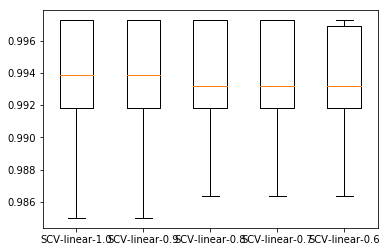

In [9]:
X, y = load_dataset()
models = define_models()
results = evaluate_models(X, y, models)
summarize_results(results, top_n=5)

Sólo para tener un ranking de todos los modelos, llamemos nuevamente a la función `summarize_results` pero desactivando la opción de graficar.

In [10]:
summarize_results(results, top_n=len(results), plot=False)

--------
Rank=1, Name=SCV-linear-1.0, Score=0.9934480277920665 (+/- 0.003944167917138149)
Rank=2, Name=SCV-linear-0.9, Score=0.9934480277920665 (+/- 0.003944167917138149)
Rank=3, Name=SCV-linear-0.8, Score=0.9934478414182303 (+/- 0.0037011376799861427)
Rank=4, Name=SCV-linear-0.7, Score=0.9934478414182303 (+/- 0.0037011376799861427)
Rank=5, Name=SCV-linear-0.6, Score=0.9934476550443941 (+/- 0.0034405415852301552)
Rank=6, Name=SCV-linear-0.5, Score=0.9930381917264925 (+/- 0.0032537779494845823)
Rank=7, Name=SCV-linear-0.4, Score=0.9926285420347549 (+/- 0.003062619363378767)
Rank=8, Name=SCV-linear-0.3, Score=0.9923558771125475 (+/- 0.003515026977485452)
Rank=9, Name=SGDClassifier, Score=0.9916728170032577 (+/- 0.004665749258440611)
Rank=10, Name=SCV-linear-0.2, Score=0.9915371368505802 (+/- 0.004474483442540483)
Rank=11, Name=RidgeClassifier-0.8, Score=0.9912639128068644 (+/- 0.004574692652304791)
Rank=12, Name=RidgeClassifier-1.0, Score=0.9911274871588427 (+/- 0.004657207420451205)
Ran

## Conclusión

Entrenamos cada modelo usando el _framework_ descrito en las celdas anteriores para determinar el poder de aprendizaje de cada uno.

Es notable que SVC se desempeña terribelemente mal cuando utiliza un kernel polinómico, en vez de uno lineal.

Debemos destacar que los modelos que mejor lo hacen son variaciones de SVC con kernel lineal y diferentes valores de penalización (C).

No obstante, en pos de la diversidad, promoveremos los siguientes cuatro modelos a la fase de optimización:

 - Rank=1, Name=**SVC-linear-1.0**, Score=**0.9934480277920665 (+/- 0.003944167917138149)**
 - Rank=9, Name=**SGDClassifier**, Score=**0.9916728170032577 (+/- 0.004665749258440611)**
 - Rank=11, Name=**RidgeClassifier-0.8**, Score=**0.9912639128068644 (+/- 0.004574692652304791)**
 - Rank=24, Name=**KNeighborsClassifier-4**, Score=**0.9892162234696844 (+/- 0.00614647322899209)**
 
Debemos recordar que estos modelos ya están rindiendo bastante bien con nuestra selección inicial de parámetros, pero, de todas formas, intentaremos exprimirles la mayor cantidad de desempeño que podamos.